In [495]:
%pylab inline
import os

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cov', 'mat', 'diff']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [496]:
file_root = '/mnt/store1/oliverphilcox/3PCF_QPM/full_run.v01/'

### Must correct for wrong $RRR$ weight norm here

In [497]:
good_mocks=[]
all_zeta = []
all_xi = []
gg=[]
for i in range(1,300):
    in_dat = file_root+'3pcf_output_%s.npz'%str(i).zfill(4)
    if os.path.exists(in_dat):
        gg.append(i)
        dat = np.load(in_dat)
        this_zeta = dat.f.zeta*pow(1.5,3)
        
        #if i in bad_index:
        #    continue
        
        
        if not np.isnan(np.sum(this_zeta)):
            
            if np.abs(np.sum(this_zeta))>1e5:
                continue
            
            good_mocks.append(i)
            
            # normalize correctly
            for b1 in range(len(this_zeta)):
                for b2 in range(b1):
                    this_zeta[b1,b2,1:]*=this_zeta[b1,b2,0]
                    # by symmetry
                    this_zeta[b2,b1,:]=this_zeta[b1,b2,:]

            all_zeta.append(this_zeta)
            all_xi.append(dat.f.xi*pow(1.5,2))
        else:
            os.remove(in_dat)
            
all_zeta = np.asarray(all_zeta)
all_xi = np.asarray(all_xi)

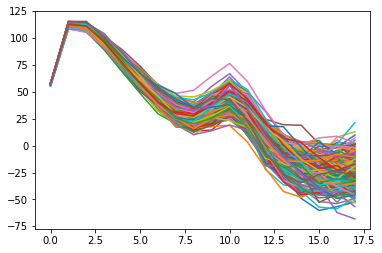

In [498]:
for i in range(n_mocks):
    plt.plot(r_bins**2*all_xi[i])

In [499]:
bad_index=np.asarray(good_mocks)[r_bins[1]**2*all_xi[:,1]<100]

In [500]:
bad_index=np.concatenate([bad_index,[148]])

In [501]:
n_mocks = len(good_mocks)
print("N_mocks = %d"%n_mocks)

N_mocks = 216


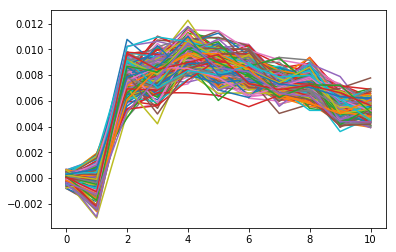

In [502]:
for i in range(n_mocks):
    if i!=69:
        plt.plot(all_zeta[i][5,7,:])

In [503]:
good_mocks[69]

123

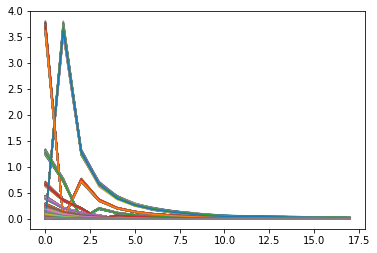

In [504]:
for i in range(n_mocks):
    plt.plot(all_zeta[i][:,:,2])

In [505]:
r_bins = np.linspace(5,175,dat.f.bins)
ells = np.arange(dat.f.order+1)

In [506]:
delta_r = r_bins[1]-r_bins[0]
r_min = r_bins-delta_r/2
n=len(r_min)
min_r_bin = 7

vol_r = 4.*np.pi/3.*((r_min+delta_r)**3-r_min**3)

zeta_compress = np.zeros([n_mocks,len(r_bins)-min_r_bin,dat.f.order+1])

for i in range(n_mocks):
    denom = np.zeros([len(r_bins)-min_r_bin])

    for b1 in range(min_r_bin,n):
        for b2 in range(3,b1-3):
            zeta_compress[i,b1-min_r_bin,:]+=all_zeta[i,b1,b2,:]*vol_r[b2]
            denom[b1-min_r_bin]+=vol_r[b2]
        zeta_compress[i,b1-min_r_bin,:]/=denom[b1-min_r_bin]
            
    
#     len(r,r1 in enumerate(r_min):
#         ct=0
#         for b2,r2 in enumerate(r_min):
#             if r2>=3*delta_r and r2<r1-3*delta_r:
#                 vol_2 = 4.*np.pi/3.*((r2+delta_r)**3-r2**3)
#                 zeta_compress[i,b1,:]+=all_zeta[i,b1,b2,:]*vol_2
#                 denom[b1]+=vol_2
#                 ct+=1
#         if ct>0:
#             zeta_compress[i,b1]/=denom[b1]

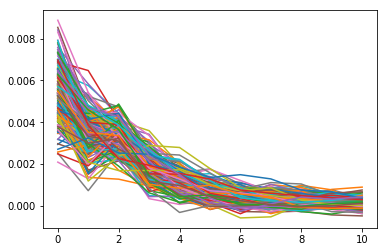

In [507]:
for i in range(n_mocks):
    plt.plot(zeta_compress[i,:,5])

## These fit with SE paper!


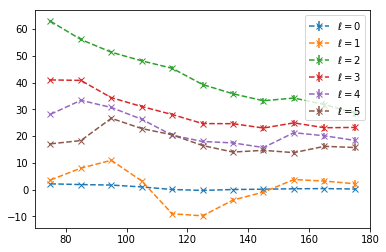

In [508]:
for l_i,ell in enumerate(ells[:6]):
    plt.errorbar(r_bins[min_r_bin:],(r_bins[min_r_bin:]/10.)**4*zeta_compress[:,:,l_i].mean(axis=0),
                 (r_bins[min_r_bin:]/10)**4.*zeta_compress[:,:,l_i].std(axis=0)/np.sqrt(n_mocks),label=r'$\ell=%d$'%(ell),
                marker='x',ls='--')
plt.legend()

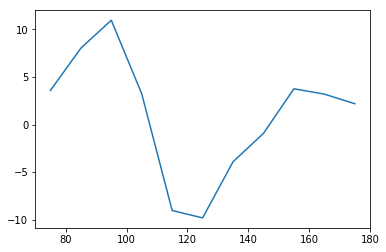

In [509]:
plt.plot(r_bins[min_r_bin:],zeta_compress[:,:,1].mean(axis=0)*(r_bins[min_r_bin:]/10)**4)

In [510]:
zeta_compress_ravel=[]
for i in range(n_mocks):
    zeta_compress_ravel.append(zeta_compress[i].T.ravel())
zeta_mean = np.mean(np.asarray(zeta_compress_ravel),axis=0)

In [511]:
cov = np.zeros([len(zeta_compress_ravel[0]),len(zeta_compress_ravel[0])])
for i in range(n_mocks):
    diff = zeta_compress_ravel[i]-zeta_mean
    cov+=np.matmul(diff.reshape(-1,1),diff.reshape(1,-1))
cov/=n_mocks-1

In [512]:
red = np.zeros_like(cov)
for i in range(len(cov)):
    for j in range(len(cov)):
        red[i,j]=cov[i,j]/np.sqrt(cov[i,i]*cov[j,j])

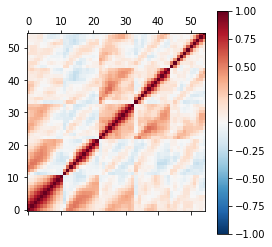

In [513]:
plt.matshow(red,cmap=cm.RdBu_r,vmax=1,vmin=-1)
plt.xlim([-0.5,55-0.5])
plt.ylim([-0.5,55-0.5])
plt.colorbar();

In [514]:
zeta_compress_cut = zeta_compress[:,:,:]
zeta_ravels=[]
for i in range(n_mocks):
    zeta_ravels.append(zeta_compress_cut[i].T.ravel())
zeta_ravels = np.asarray(zeta_ravels)

In [515]:
zeta_compress_cut.shape

(216, 11, 11)

In [516]:
cov_zeta=np.cov(zeta_ravels.T)
red_cov_zeta = np.zeros_like(cov_zeta)
for i in range(len(cov_zeta)):
    for j in range(len(cov_zeta)):
        red_cov_zeta[i,j]=cov_zeta[i,j]/np.sqrt(cov_zeta[i,i]*cov_zeta[j,j])

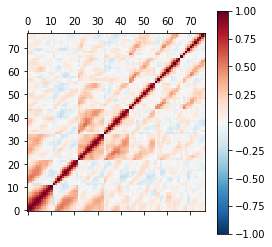

In [517]:
plt.matshow(red_cov_zeta,cmap=cm.RdBu_r,vmax=1,vmin=-1)
plt.ylim([0-0.5,77-0.5])
plt.xlim([0-0.5,77-0.5])
plt.colorbar();

In [518]:
ravel_zeta_compress = np.zeros([n_mocks,len(ells)*len(r_bins[7:])])
for i in range(n_mocks):
    ravel_zeta_compress[i,:]=zeta_compress[i][:,:].T.ravel()
cov_mat=np.cov(ravel_zeta_compress.T)
red_mat = np.zeros_like(cov_mat)
for i in range(len(cov_mat)):
    for j in range(len(cov_mat)):
        red_mat[i,j]=cov_mat[i,j]/np.sqrt(cov_mat[i,i]*cov_mat[j,j])

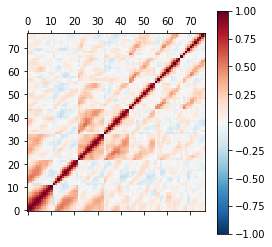

In [519]:
plt.matshow(red_mat,cmap=cm.RdBu_r,vmax=1,vmin=-1)
plt.ylim([0-0.5,77-0.5])
plt.xlim([0-0.5,77-0.5])
plt.colorbar();

In [520]:
r1r2_sq = np.matmul((r_bins**2.).reshape(-1,1),(r_bins**2).reshape(1,-1))

<Figure size 432x288 with 0 Axes>

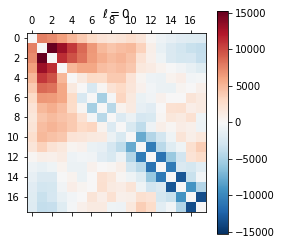

<Figure size 432x288 with 0 Axes>

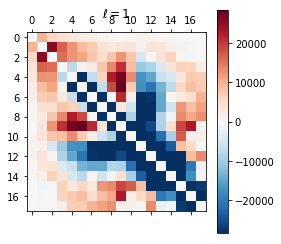

<Figure size 432x288 with 0 Axes>

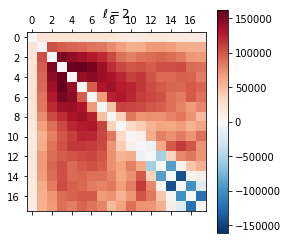

<Figure size 432x288 with 0 Axes>

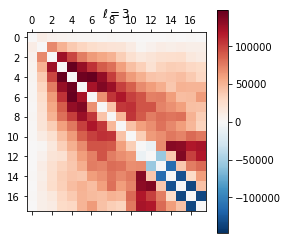

<Figure size 432x288 with 0 Axes>

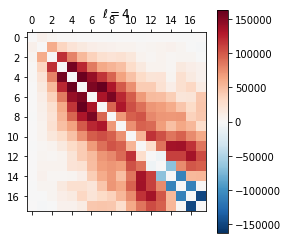

<Figure size 432x288 with 0 Axes>

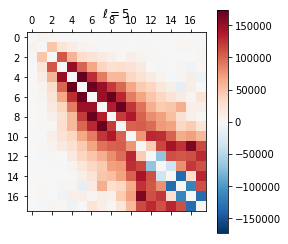

In [521]:
for ell in range(6):
    plt.figure();
    mat=all_zeta.mean(axis=0)[:,:,ell]*r1r2_sq[:,:]
    vmax = np.percentile(mat.ravel(),99.9)
    plt.matshow(mat,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax)
    plt.colorbar();
    plt.title(r'$\ell = %d$'%ell);

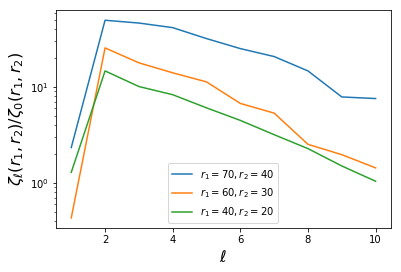

In [522]:
inds = [[7,4],[6,3],[4,2]]
for ind in inds:
    plt.plot(ells[1:],all_zeta.mean(axis=0)[ind[0],ind[1],1:]/all_zeta.mean(axis=0)[ind[0],ind[1],0],
            label=r'$r_1 = %d, r_2 = %d$'%(ind[0]*10,ind[1]*10))
plt.ylabel(r'$\zeta_\ell(r_1,r_2)/\zeta_0(r_1,r_2)$',fontsize=16)
plt.xlabel(r'$\ell$',fontsize=16)
plt.legend();
plt.yscale('log')

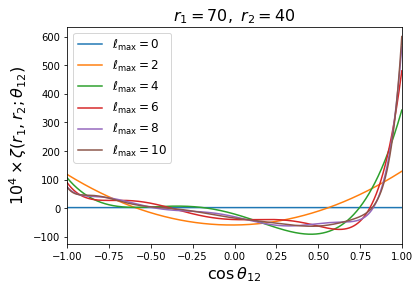

In [523]:
from scipy.special import legendre

for ell_max in [0,2,4,6,8,10]:
    these_ell = np.arange(0,ell_max+1)
    mus = np.arange(-1,1,0.001)
    ddat=[]
    for ell in these_ell:
        ddat.append(legendre(ell)(mus)*all_zeta.mean(axis=0)[7,4][ell])
    dddat = np.sum(np.asarray(ddat),axis=0)
    plt.plot(mus,1e4*dddat,label=r'$\ell_\mathrm{max} = %d$'%ell_max)
plt.legend(fontsize=12);
plt.xlim([-1,1])
plt.xlabel(r'$\cos\,{\theta_{12}}$',fontsize=16)
plt.ylabel(r'$10^4\times \zeta(r_1,r_2;\theta_{12})$',fontsize=16)
plt.title(r'$r_1 = 70,\,\,r_2 = 40$',fontsize=16);

<ErrorbarContainer object of 3 artists>

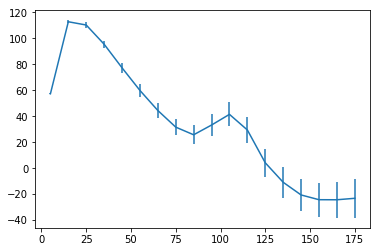

In [524]:
plt.errorbar(r_bins,all_xi.mean(axis=0)*r_bins**2,all_xi.std(axis=0)*r_bins**2,marker='')